In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import prep_plays
import wrangle_plays_data


plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
week1 = pd.read_csv('week1.csv')
#plays = pd.read_csv('plays.csv')
#plays = pd.read_csv('plays.csv')

plays.head()

Acquire.py Loaded Successfully
Prep.py Loaded Successfully
Wrangle.py Loaded Successfully


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,...,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,...,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,...,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,...,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,...,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,...,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


In [2]:
plays = plays[plays.playType == 'play_type_pass']


In [3]:
df = prep_plays.prep_plays_data()

In [4]:
pd.set_option('display.max_columns',None)
df

,playDescription,quarter,down,yardsToGo,team_by_comp_yds,defendersInTheBox,numberOfPassRushers,QB_under_pressure,gameClock,absoluteYardlineNumber,epa,pass_stopped,playResult,RB,TE,WR,DL,LB,DB,EMPTY,I_FORM,JUMBO,PISTOL,SHOTGUN,SINGLEBACK,WILDCAT,four_three,three_four,nickel,dime
0,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,3,7.0,4.0,0.0,15:00:00,90.0,0.261827,0,10,2,1,2,4,2,5,0,1,0,0,0,0,0,0,0,1,0
1,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,3,7.0,4.0,0.0,13:10:00,49.0,-0.372360,1,0,1,1,3,4,2,5,0,0,0,0,0,1,0,0,0,1,0
2,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,3,6.0,4.0,0.0,13:05:00,49.0,-0.702779,1,0,2,1,2,4,2,5,0,0,0,0,1,0,0,0,0,1,0
3,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,3,6.0,5.0,1.0,13:01:00,49.0,3.047530,0,33,1,1,3,4,1,6,0,0,0,0,1,0,0,0,0,0,1
4,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,3,8.0,6.0,0.0,10:59:00,11.0,-0.842272,1,0,2,3,0,6,3,2,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,(2:19) (Shotgun) P.Rivers pass short right to ...,4,2,2,19,6.0,4.0,0.0,02:19:00,77.0,0.460543,0,7,1,1,3,1,5,5,0,0,0,0,1,0,0,0,0,1,0
17003,(2:00) (Shotgun) P.Rivers pass short left to K...,4,1,10,19,4.0,5.0,0.0,02:00:00,70.0,0.712741,0,17,1,1,3,1,4,6,0,0,0,0,1,0,0,0,0,0,1
17004,(1:41) (Shotgun) P.Rivers pass incomplete shor...,4,1,10,19,5.0,5.0,0.0,01:41:00,53.0,-0.229687,1,0,1,1,3,1,4,6,0,0,0,0,1,0,0,0,0,0,1
17005,(1:37) (Shotgun) P.Rivers pass incomplete deep...,4,2,10,19,4.0,4.0,0.0,01:37:00,53.0,-0.460746,1,0,1,1,3,1,4,6,0,0,0,0,1,0,0,0,0,0,1


# Does a teams offense matter for a successful defensive pass interruption?

$H_o$ : A team's offense is not correlated to a defensive pass interruption.

$H_a$ : A team's offense is correlated with a defensive pass interruption.

$a$ : $.05$

Pearsonr Correlation Test
> Is there a linear relationship with team_by_comp_yds and pass_stopped?

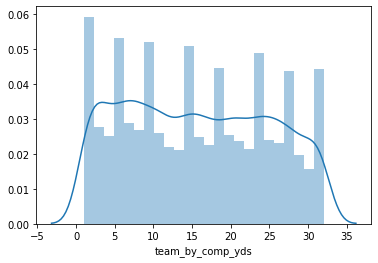

In [5]:
sns.distplot(df.team_by_comp_yds)

In [6]:
corr, p = stats.pearsonr(df.team_by_comp_yds, df.pass_stopped)
corr, p
print('p:', p)
if p < .05:
    print('We reject the null hypothesis that there is no relationship with a teams offense and pass blocked.')
else:
    print('We fail to reject the null hypothesis.')

p: 2.029505834470611e-09
We reject the null hypothesis that there is no relationship with a teams offense and pass blocked.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17001 entries, 0 to 17006
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   playDescription         17001 non-null  object 
 1   quarter                 17001 non-null  int64  
 2   down                    17001 non-null  int64  
 3   yardsToGo               17001 non-null  int64  
 4   team_by_comp_yds        17001 non-null  int64  
 5   defendersInTheBox       17001 non-null  float64
 6   numberOfPassRushers     17001 non-null  float64
 7   QB_under_pressure       17001 non-null  object 
 8   gameClock               17001 non-null  object 
 9   absoluteYardlineNumber  17001 non-null  float64
 10  epa                     17001 non-null  float64
 11  pass_stopped            17001 non-null  int64  
 12  playResult              17001 non-null  int64  
 13  RB                      17001 non-null  object 
 14  TE                      17001 non-null

____________________

# Logistic Regression Modeling
> All features except playDescription, and gameClock.

In [61]:
#X = df[['quarter', 'down', 'yardsToGo', 'team_by_comp_yds', 'defendersInTheBox',
#       'numberOfPassRushers', 'QB_under_pressure', 'absoluteYardlineNumber',
#       'epa', 'playResult', 'RB', 'TE', 'WR', 'DL', 'LB', 'DB', 'EMPTY',
#       'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT',
#       'four_three', 'three_four', 'nickel', 'dime']]
#X = df.drop(columns= ['playDescription','pass_stopped', 'gameClock','playResult','EMPTY', 'I_FORM', 'JUMBO',
#                                     'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT',
#                                     'RB', 'TE', 'WR'])
# BEST feature for KNN
X = df[['yardsToGo', 'defendersInTheBox', 'numberOfPassRushers',
       'QB_under_pressure', 'epa', 'playResult', 'RB', 'TE', 'WR', 'DL', 'LB',
       'DB', 'EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK']]
# BEST feature for Logistic regression
#X = df.drop(columns= ['playDescription','pass_stopped', 'gameClock'])
y = df[['pass_stopped']]

In [62]:
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size = .30, random_state = 123)

X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size = .40, random_state = 123)

print("train: ", X_train.shape, ", validate: ", X_validate.shape, ", test: ", X_test.shape)
print("train: ", y_train.shape, ", validate: ", y_validate.shape, ", test: ", y_test.shape)

train:  (7140, 18) , validate:  (4760, 18) , test:  (5101, 18)
train:  (7140, 1) , validate:  (4760, 1) , test:  (5101, 1)


In [63]:
scaler = MinMaxScaler(copy = True).fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns.values).set_index([X_train.index.values])
X_validate_scaled = pd.DataFrame(X_validate_scaled, columns = X_validate.columns.values).set_index([X_validate.index.values])
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns.values).set_index([X_test.index.values])

In [64]:
# creating the object
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

# fit the model
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_train)

y_pred_proba = logit.predict_proba(X_train)

print('Accuracy of Logistic Regression classifier on TRAIN-unscaled set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Coefficient: 
 [[ 0.08017228 -0.01692248  0.35482489  0.47341216 -0.13208364 -0.63742871
  -0.22962149  0.10344743  0.18184386  0.27214556  0.22595566  0.51454047
  -1.95166876 -1.59211826  0.48743749 -2.23380382 -1.50403491 -1.68337164]]
Intercept: 
 [0.09940961]
Accuracy of Logistic Regression classifier on TRAIN-unscaled set: 0.72


In [65]:
print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))

[[2582 2024]
 [   6 2528]]
              precision    recall  f1-score   support

           0       1.00      0.56      0.72      4606
           1       0.56      1.00      0.71      2534

    accuracy                           0.72      7140
   macro avg       0.78      0.78      0.72      7140
weighted avg       0.84      0.72      0.72      7140



In [66]:
# SCALED creating the object
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

# fit the model
logit.fit(X_train_scaled, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_train_scaled)

y_pred_proba = logit.predict_proba(X_train_scaled)

print('Accuracy of Logistic Regression classifier on TRAIN set: {:.2f}'
     .format(logit.score(X_train_scaled, y_train)))

Coefficient: 
 [[  1.01697578   0.56579584   1.90326615   0.61755851 -17.89838567
  -48.60138924   0.66093404   1.8620208    2.37148776   1.88949182
    1.84781087   3.50726064  -1.74462539  -1.38361568  -0.47210111
   -2.21451743  -1.4970626   -1.60707578]]
Intercept: 
 [27.6468874]
Accuracy of Logistic Regression classifier on TRAIN set: 0.63


In [67]:
print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))

[[1937 2669]
 [   6 2528]]
              precision    recall  f1-score   support

           0       1.00      0.42      0.59      4606
           1       0.49      1.00      0.65      2534

    accuracy                           0.63      7140
   macro avg       0.74      0.71      0.62      7140
weighted avg       0.82      0.63      0.61      7140



### On to Validate

In [68]:
### Non-scaled Data

# creating the object
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

# fit the model
logit.fit(X_validate, y_validate)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_validate)

y_pred_proba = logit.predict_proba(X_validate)

print('Accuracy of Logistic Regression classifier on VALIDATE-unscaled set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))

print(confusion_matrix(y_validate, y_pred))

print(classification_report(y_validate, y_pred))

Coefficient: 
 [[-0.03156946 -0.03080304  0.46176421  0.24782807 -0.39317943 -0.57676737
  -0.0131979   0.09652699  0.26012521  0.0159936   0.20721723  0.72225763
  -2.22333888 -1.39297572  1.02060118 -2.34964398 -1.67292983 -1.60590903]]
Intercept: 
 [0.08153184]
Accuracy of Logistic Regression classifier on VALIDATE-unscaled set: 0.70
[[1747 1416]
 [   5 1592]]
              precision    recall  f1-score   support

           0       1.00      0.55      0.71      3163
           1       0.53      1.00      0.69      1597

    accuracy                           0.70      4760
   macro avg       0.76      0.77      0.70      4760
weighted avg       0.84      0.70      0.70      4760



In [69]:
### scaled Data

# creating the object
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

# fit the model
logit.fit(X_validate_scaled, y_validate)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_validate_scaled)

y_pred_proba = logit.predict_proba(X_validate_scaled)

print('Accuracy of Logistic Regression classifier on VALIDATE set: {:.2f}'
     .format(logit.score(X_validate_scaled, y_validate)))

print(confusion_matrix(y_validate, y_pred))

print(classification_report(y_validate, y_pred))

Coefficient: 
 [[ -1.23511387   0.66368304   2.21207115   0.43114469 -21.83890457
  -39.54181936  -0.16878748  -0.14028292   0.47941207  -1.19133789
   -0.33420532   1.78558148  -2.4061689   -2.09687068   0.04388285
   -2.45385434  -2.17256378  -1.99582383]]
Intercept: 
 [32.5004525]
Accuracy of Logistic Regression classifier on VALIDATE set: 0.60
[[1253 1910]
 [   4 1593]]
              precision    recall  f1-score   support

           0       1.00      0.40      0.57      3163
           1       0.45      1.00      0.62      1597

    accuracy                           0.60      4760
   macro avg       0.73      0.70      0.60      4760
weighted avg       0.81      0.60      0.59      4760



### On to test

In [70]:
### Non-scaled Data

# creating the object
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

# fit the model
logit.fit(X_test, y_test)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_test)

y_pred_proba = logit.predict_proba(X_test)

print('Accuracy of Logistic Regression classifier on TEST-unscaled set: {:.2f}'
     .format(logit.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Coefficient: 
 [[ 0.03416748  0.25711821  0.36076095  0.64878883 -0.36592153 -0.73164187
  -0.01137746  0.18738682  0.1717741   0.08823659  0.04779047  0.40867517
  -1.13669722 -1.41885176 -1.1059499  -2.15629561 -1.82884712 -1.04006205]]
Intercept: 
 [0.0839247]
Accuracy of Logistic Regression classifier on TEST-unscaled set: 0.77
[[2097 1188]
 [   3 1813]]
              precision    recall  f1-score   support

           0       1.00      0.64      0.78      3285
           1       0.60      1.00      0.75      1816

    accuracy                           0.77      5101
   macro avg       0.80      0.82      0.77      5101
weighted avg       0.86      0.77      0.77      5101



In [71]:
### scaled Data

# creating the object
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

# fit the model
logit.fit(X_test_scaled, y_test)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

y_pred = logit.predict(X_test_scaled)

y_pred_proba = logit.predict_proba(X_test_scaled)

print('Accuracy of Logistic Regression classifier on TEST set: {:.2f}'
     .format(logit.score(X_test_scaled, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Coefficient: 
 [[  0.06204131   1.66314937   1.84786244   0.81093883 -23.41279819
  -41.97937711   0.91856103   1.0096226    1.3805343    1.01313906
    0.83142619   2.37626511  -1.58399945  -1.61287979  -1.19757188
   -2.04142538  -1.99206491  -1.62905853]]
Intercept: 
 [30.16418315]
Accuracy of Logistic Regression classifier on TEST set: 0.63
[[1404 1881]
 [   3 1813]]
              precision    recall  f1-score   support

           0       1.00      0.43      0.60      3285
           1       0.49      1.00      0.66      1816

    accuracy                           0.63      5101
   macro avg       0.74      0.71      0.63      5101
weighted avg       0.82      0.63      0.62      5101



# KNN modeling

In [72]:
# TRAIN creating object
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

y_pred = knn.predict(X_train_scaled)

y_pred_proba = knn.predict_proba(X_train_scaled)

print('Accuracy of KNN classifier on TRAIN set: {:.2f}'
     .format(knn.score(X_train_scaled, y_train)))

print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))

Accuracy of KNN classifier on TRAIN set: 0.89
[[4173  433]
 [ 370 2164]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      4606
           1       0.83      0.85      0.84      2534

    accuracy                           0.89      7140
   macro avg       0.88      0.88      0.88      7140
weighted avg       0.89      0.89      0.89      7140



In [73]:
# VALIDATE creating object
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn.fit(X_validate_scaled, y_validate)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

y_pred = knn.predict(X_validate_scaled)

y_pred_proba = knn.predict_proba(X_validate_scaled)

print('Accuracy of KNN classifier on Validate set: {:.2f}'
     .format(knn.score(X_validate_scaled, y_validate)))

print(confusion_matrix(y_validate, y_pred))

print(classification_report(y_validate, y_pred))

Accuracy of KNN classifier on Validate set: 0.87
[[2897  266]
 [ 332 1265]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3163
           1       0.83      0.79      0.81      1597

    accuracy                           0.87      4760
   macro avg       0.86      0.85      0.86      4760
weighted avg       0.87      0.87      0.87      4760



In [74]:
# TEST creating object
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn.fit(X_test_scaled, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

y_pred = knn.predict(X_test_scaled)

y_pred_proba = knn.predict_proba(X_test_scaled)

print('Accuracy of KNN classifier on TEST set: {:.2f}'
     .format(knn.score(X_test_scaled, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Accuracy of KNN classifier on TEST set: 0.88
[[2971  314]
 [ 274 1542]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3285
           1       0.83      0.85      0.84      1816

    accuracy                           0.88      5101
   macro avg       0.87      0.88      0.87      5101
weighted avg       0.89      0.88      0.89      5101



([<matplotlib.axis.XTick at 0x7ffbdec665d0>,
 <a list of 5 Text xticklabel objects>)

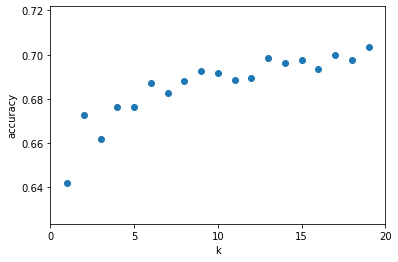

In [22]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

### Feature Engineering

In [23]:
### RFE

number_of_features_list=np.arange(1,29)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 18
Score with 18 features: 0.380594


In [60]:
cols = list(X_train_scaled.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 18)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['yardsToGo', 'defendersInTheBox', 'numberOfPassRushers',
       'QB_under_pressure', 'epa', 'playResult', 'RB', 'TE', 'WR', 'DL', 'LB',
       'DB', 'EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK'],
      dtype='object')


### using rfe features

In [25]:
#X = df[['quarter', 'down', 'yardsToGo', 'team_by_comp_yds', 'defendersInTheBox',
#       'numberOfPassRushers', 'QB_under_pressure', 'absoluteYardlineNumber',
#       'epa', 'playResult', 'RB', 'TE', 'WR', 'DL', 'LB', 'DB', 'EMPTY',
#       'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT',
#       'four_three', 'three_four', 'nickel', 'dime']]
X = df.drop(columns= ['playDescription','pass_stopped', 'gameClock'])
y = df[['pass_stopped']]

In [26]:
X_train

,quarter,down,yardsToGo,team_by_comp_yds,defendersInTheBox,numberOfPassRushers,QB_under_pressure,absoluteYardlineNumber,epa,playResult,RB,TE,WR,DL,LB,DB,EMPTY,I_FORM,JUMBO,PISTOL,SHOTGUN,SINGLEBACK,WILDCAT,four_three,three_four,nickel,dime
4170,2,2,4,2,6.0,4.0,0.0,46.0,-0.611122,0,1,1,3,2,4,5,0,0,0,0,1,0,0,0,0,1,0
14076,4,1,10,12,6.0,5.0,0.0,65.0,-0.032445,6,1,2,2,3,4,4,1,0,0,0,0,0,0,0,1,0,0
15897,3,2,3,23,8.0,7.0,0.0,103.0,1.789159,7,1,1,3,4,2,5,0,0,0,0,1,0,0,0,0,1,0
2723,3,1,10,16,7.0,4.0,0.0,43.0,-0.025190,8,1,2,2,4,3,4,0,0,0,0,0,1,0,1,0,0,0
632,4,1,9,32,6.0,4.0,0.0,101.0,-0.066855,1,1,1,3,2,4,5,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,2,1,10,4,7.0,4.0,0.0,60.0,2.510391,42,1,1,3,4,2,5,0,0,0,0,0,1,0,0,0,1,0
10063,2,2,3,30,5.0,4.0,0.0,84.0,0.589207,6,1,1,3,2,3,6,0,0,0,0,1,0,0,0,0,0,1
10013,3,3,8,17,6.0,4.0,0.0,99.0,2.463213,11,1,1,3,2,3,6,1,0,0,0,0,0,0,0,0,0,1
3002,4,2,3,30,7.0,4.0,0.0,26.0,0.759128,8,1,1,3,4,2,5,0,0,0,0,0,1,0,0,0,1,0


# wangle-functions

In [27]:
#plays["offenseFormation"].replace({"I_FORM": "IFORM"}, inplace=True)

#plays = plays[plays['offenseFormation'].notna()]

#plays = plays[plays['typeDropback'].notna()]

#plays.personnelD.isna().sum()



#ohe = OneHotEncoder(sparse=False)

#ohe.fit_transform(plays[['personnelO']]).shape

#plays['possessionTeam'].replace({'TRADITIONAL':0,'SCRAMBLE_ROLLOUT_RIGHT':1,
#                                 'SCRAMBLE':2,'DESIGNED_ROLLOUT_RIGHT':3,
#                                 'SCRAMBLE_ROLLOUT_LEFT':4,'DESIGNED_ROLLOUT_LEFT':5,
#                                 'UNKNOWN':6}, inplace=True)

#plays['offenseFormation'].replace({'SHOTGUN':0,'SINGLEBACK':1,'EMPTY':2,'I_FORM':3,
#                                   'PISTOL':4,'JUMBO':5,'WILDCAT':6}, inplace=True)

#plays['possessionTeam'].replace({'PIT':0,'GB':1,'TB':2,'IND':3,'ATL':4,'PHI':5,'NYG':6,'DET':7,
#                                'CLE':8,'MIN':9,'LA':10,'OAK':11,'NE':12,'BAL':13,'CAR':14,
#                                'DAL':15,'CIN':16,'DEN':17,'JAX':18,'KC':19,'HOU':20,'WAS':21,
#                                'SF':22,'NYJ':23,'ARI':24,'NO':25,'BUF':26,'CHI':27,'MIA':28,
#                                'LAC':29,'TEN':30,'SEA':31}, inplace=True)

### sklearn pipeline column transformer w/ one hot encoding

In [28]:
#print('Decision Tree with 7 features')
#print('Accuracy:',cross_val_score(estimator = clf, pipe_dt, X_train, y_train, cv=5, n_jobs=4,scoring='accuracy').mean())
#print('Precision:',cross_val_score(pipe_nb, X_train, y_train, cv=5, scoring='precision').mean())
#print('Recall:',cross_val_score(pipe_nb, X_train, y_train, cv=5, scoring='recall').mean())

In [29]:
#models = [GaussianNB(), DecisionTreeClassifier(), SVC(), LogisticRegression(solver='lbfgs')]
#names = ["Naive Bayes", "Decision Tree", "SVM","Logistic Regression"]
#for model, name in zip(models, names):
#    print(name)
#    for score in ["accuracy", "precision", "recall"]:
#        print(score)
#        print (cross_val_score(pipe, X_train, y_train, cv=5, scoring=score).mean())

In [30]:
#y_pred = logit.predict(pipe, X_train)